In [ ]:
!pip install torchmetrics


In [ ]:
from google.colab import drive
import os
from PIL import Image
import tifffile
import numpy as np

In [ ]:
# torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader , Dataset,random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import jaccard_index
import torch.optim as optim

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, image_paths, mask_paths, transform,target_transform):
    self.image_folder = image_paths
    self.mask_folder = mask_paths
    self.transform = transform
    self.target_transform = target_transform
    self.images = sorted(os.listdir(self.image_folder))
    self.masks = sorted(os.listdir(self.mask_folder))
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = os.path.join(self.image_folder, self.images[idx])
    mask_path = os.path.join(self.mask_folder, self.masks[idx])

    image= tifffile.imread(image_path)
    mask=Image.open(mask_path)

    if self.transform:
            image = self.transform(image)
    if self.target_transform:
            mask = torch.from_numpy(np.array(mask)).float()

    return image ,mask

In [ ]:
images_path="/content/drive/MyDrive/data/images"
mask_path="/content/drive/MyDrive/data/labels"

In [ ]:
transfer = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
mask_transfer=transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [ ]:
SegmentationDataset=SegmentationDataset(images_path,mask_path,transfer,mask_transfer)

In [ ]:
img,mask=SegmentationDataset[0]

In [ ]:
print(img.shape)
print(mask.shape)

torch.Size([12, 128, 128])
torch.Size([128, 128])


In [ ]:
print(f"dataset number of sample = {len(SegmentationDataset)}")

dataset number of sample = 306


### Split data

In [ ]:
train_size = int(0.8 * len(SegmentationDataset))
val_size=int(0.1 * len(SegmentationDataset))
test_size  = len(SegmentationDataset) - train_size - val_size

train_dataset,val_dataset,test_dataset = random_split(SegmentationDataset, [train_size,val_size,test_size])


In [ ]:
print(f"size of train dataset is {len(train_dataset)}")
print(f"size of val dataset is {len(val_dataset)}")
print(f"size of test dataset is {len(test_dataset)}")

size of train dataset is 244
size of val dataset is 30
size of test dataset is 32


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

### our model Unet

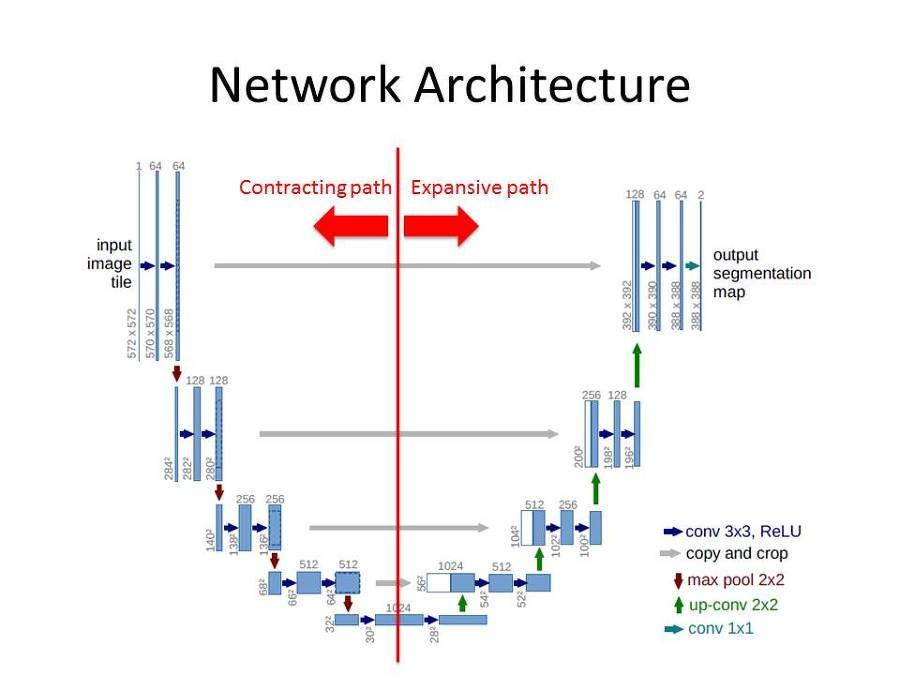

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        # Encoder
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )

        # Decoder
        self.up_trans1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up1 = nn.Sequential(
            nn.Conv2d(in_channels=512+512, out_channels=512, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )

        self.up_trans2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up2 = nn.Sequential(
            nn.Conv2d(in_channels=256+256, out_channels=256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )

        self.up_trans3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up3 = nn.Sequential(
            nn.Conv2d(in_channels=128+128, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )

        self.up_trans4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up4 = nn.Sequential(
            nn.Conv2d(in_channels=64+64, out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )

        # Output
        self.out = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        x4 = self.down4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))

        # Decoder
        x = self.up_trans1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.up1(x)

        x = self.up_trans2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.up2(x)

        x = self.up_trans3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up3(x)

        x = self.up_trans4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up4(x)

        return self.out(x)


In [ ]:
def train(num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)

    for epoch in range(num_epochs):
        # ------------------ TRAIN ------------------
        model.train()
        train_total_loss = 0
        train_ious = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device).float(), targets.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_bin = (preds > 0.5).float()
            train_iou = jaccard_index(preds_bin, targets.int(), task="binary")
            train_ious.append(train_iou.item())

        avg_train_loss = train_total_loss / len(train_loader)
        avg_train_iou = sum(train_ious) / len(train_ious)

        # ------------------ VALIDATION ------------------
        model.eval()
        val_total_loss = 0
        val_ious = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device).float(), targets.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_total_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds_bin = (preds > 0.5).float()
                val_iou = jaccard_index(preds_bin, targets.int(), task="binary")
                val_ious.append(val_iou.item())

        avg_val_loss = val_total_loss / len(val_loader)
        avg_val_iou = sum(val_ious) / len(val_ious)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f} | IoU: {avg_train_iou:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f}")


In [ ]:
train(50)

Epoch [1/50]
  Train Loss: 2.0802 | IoU: 0.0673
  Val   Loss: 0.6558 | IoU: 0.0213
Epoch [2/50]
  Train Loss: 0.6761 | IoU: 0.0291
  Val   Loss: 0.6784 | IoU: 0.0001
Epoch [3/50]
  Train Loss: 0.6472 | IoU: 0.0031
  Val   Loss: 0.6581 | IoU: 0.0006


KeyboardInterrupt: 